In this section we will illustrate the computation of Taxed PageRank in a distributed way using MapReduce in **pyspark**. Note however that this only illustrated the case when the PageRank vector $v$ fits in memory. For cases where $v$ does not fit in memory, techniques like *striping* and *blocking* should be employed, as discussed in the previous section.

In [1]:
from pyspark import SparkContext
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import csv

import linkana  # our Link Analysis module

# Illustration of Matrix-Vector Multiplication via MapReduce

First, let's demonstrate the implementation of a matrix-vector multiplication in MapReduce.

In [2]:
sc = SparkContext('local[*]')

22/03/29 12:25:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Let's load an ilustrative example from Leskovec et al.*Mining of massive datasets* (http://www.mmds.org/) and call it Graph 4.

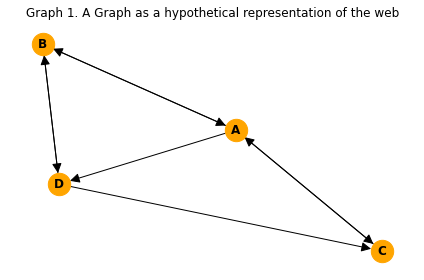

In [3]:
G4 = nx.DiGraph()
G4.add_nodes_from(["A","B","C","D"])
G4.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), 
    ("B","A"), ("B","D"),
    ("C","A"),    
    ("D","B"), ("D","C")
])

plt.figure()  
plt.title("Graph 1. A Graph as a hypothetical representation of the web")
nx.draw(G4, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

Define the transition matrix $M$ using our $linkana$ module.

In [4]:
M = linkana.transition_matrix(G4)
M

array([[0.        , 0.5       , 1.        , 0.        ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.5       , 0.        , 0.        ]])

Define the initial vector $v$

In [5]:
n = M.shape[0]
v = np.ones(n) 
n, v

(4, array([1., 1., 1., 1.]))

Define list of triples ($i$, $j$, $m_{ij}$) to be used by the Map function. The first two element of the triple contains the indices to the transition matrix while the third element refers to the value. 

In [6]:
M_elements = []
for i in range(n):
    for j in range(n):
        M_elements.append( (i,j, M[i,j]))
M_elements

[(0, 0, 0.0),
 (0, 1, 0.5),
 (0, 2, 1.0),
 (0, 3, 0.0),
 (1, 0, 0.3333333333333333),
 (1, 1, 0.0),
 (1, 2, 0.0),
 (1, 3, 0.5),
 (2, 0, 0.3333333333333333),
 (2, 1, 0.0),
 (2, 2, 0.0),
 (2, 3, 0.5),
 (3, 0, 0.3333333333333333),
 (3, 1, 0.5),
 (3, 2, 0.0),
 (3, 3, 0.0)]

Let's save this list as we will use it later when we illustrate the MapReduce reading from a file.

In [7]:
with open("graph1.csv", "w") as f:
    csv_writer = csv.writer(f)
    for row in M_elements:
        csv_writer.writerow(row)

Parallelize the list of triples

In [8]:
M_elements = sc.parallelize(M_elements)
M_elements

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274

In [9]:
type(M_elements)

pyspark.rdd.RDD

In [10]:
M_elements.take(4)

[(0, 0, 0.0), (0, 1, 0.5), (0, 2, 1.0), (0, 3, 0.0)]

**Map** 

Apply Map function calculating ($i$, $m_{ij}v_j$)

In [11]:
# Note that:
# i = x[0]
# j = x[1]
# mij = x[2]
M_elements.map(lambda x: (x[0], x[2]*v[x[1]])).collect()

[(0, 0.0),
 (0, 0.5),
 (0, 1.0),
 (0, 0.0),
 (1, 0.3333333333333333),
 (1, 0.0),
 (1, 0.0),
 (1, 0.5),
 (2, 0.3333333333333333),
 (2, 0.0),
 (2, 0.0),
 (2, 0.5),
 (3, 0.3333333333333333),
 (3, 0.5),
 (3, 0.0),
 (3, 0.0)]

**Reduce**

The Reduce function adds the values in the pairs produced by the Map function. We can chain the map function above with `reduceByKey`.

In [12]:
M_elements.map(lambda x: (x[0], x[2]*v[x[1]])
      ).reduceByKey(lambda x, y: x+y
      ).collect()

[(0, 1.5),
 (1, 0.8333333333333333),
 (2, 0.8333333333333333),
 (3, 0.8333333333333333)]

The key-value pairs above are ($i$, $v'_i$) defining $v'=Mv$

# Reading Graph Information from CSV file

Here we implement the above steps while reading from a CSV file. Note that this still just represents Matrix-vector multiplication. Let's have a quick look at our CSV file.

In [13]:
!cat graph1.csv

In [14]:
# load data from a CSV file
M_tuples= sc.textFile("graph1.csv")

# get the number of nodes of the graph 
n = round(np.sqrt(M_tuples.count()))

# initialize our vector
v = np.ones(n) 

# calculate M*v
(M_tuples.map(lambda x: x.split(','))   # CSV file contains a string of triple per row; we split it by comma
    .map(lambda x: (int(x[0]), int(x[1]), float(x[2])))  # convert string to triple of (int, int, float)
    .map(lambda x: (x[0], x[2]*v[x[1]])) #   (i, M_ij*v_j): equal to (i, Mv_ij)
    .reduceByKey(lambda x, y: x+y) # sum all values for a given key 
    .collect())

[(0, 1.5),
 (2, 0.8333333333333333),
 (1, 0.8333333333333333),
 (3, 0.8333333333333333)]

We can check this quickly

In [15]:
M.dot(v)

array([1.5       , 0.83333333, 0.83333333, 0.83333333])

# Taxed PageRank Update

Here we illustrate how to do one update of the Taxed PageRank algorithm

In [16]:
beta = 0.8
M_tuples= sc.textFile("graph1.csv")
n = round(np.sqrt(M_tuples.count()))
v = np.ones(n) 
Mv = (M_tuples.map(lambda x: x.split(','))
    .map(lambda x: (int(x[0]), int(x[1]), float(x[2])))
    .map(lambda x: (x[0], x[2]*v[x[1]]))
    .reduceByKey(lambda x, y: x+y) 
    .map(lambda x: (x[0], beta*x[1]+(1-beta)/n)) # for each Mv_ij, compute beta*Mv_ij + (1-beta)/n
    .collect())
Mv

[(0, 1.2500000000000002),
 (2, 0.7166666666666666),
 (1, 0.7166666666666666),
 (3, 0.7166666666666666)]

We can check this in the following way

In [19]:
beta * M.dot(v) + (1-beta)/n

array([1.25      , 0.71666667, 0.71666667, 0.71666667])

Or, we can call our distributed_taxed_page_rank function, with one iteration.

In [20]:
linkana.taxed_page_rank(linkana.transition_matrix(G4), max_iter=1)

array([1.25      , 0.71666667, 0.71666667, 0.71666667])

# Function for Computing PageRank using MapReduce

Finally, we define a function which we can use to compute page rank in a distributed way, given a CSV file.Note that that this assumes that the vector of PageRanks fit in memory

In [21]:
def distributed_taxed_page_rank(filename, beta=0.8, tol=10**-6, max_iter=100):
    """ Distributedly compute the Taxed PageRank of a given Transition Matrix using pyspark   
        Note that that this assumes that the vector of PageRanks fit in memory
        
    Parameters
    ----------
    filename : string
        CSV file containing triples of (i, j, M_ij) representing the (i,j) index to the transition matrix M
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    v : numpy array
        Vector of size n containing the ordinary PageRank values 
    """   

    M_tuples= sc.textFile("graph1.csv")
    n = round(np.sqrt(M_tuples.count()))
    v = np.ones(n)     
    delta = 1/tol # initialize vector difference to a large number
    i = 0
    while delta > tol:
        i += 1
        prev_v = v        
        v = (M_tuples.map(lambda x: x.split(','))
            .map(lambda x: (int(x[0]), int(x[1]), float(x[2])))
            .map(lambda x: (x[0], x[2]*v[x[1]]))
            .reduceByKey(lambda x, y: x+y) 
            .map(lambda x: (x[0], beta*x[1]+(1-beta)/n))
            .collect())
        v = np.array([v[j][1] for j in range(n)])
        delta = np.sum(np.abs(v-prev_v))  # compute L1 norm  
        if i >= max_iter:
            break
    return v    

Let's run it for one iteration to check if we are getting the correct answer.

In [22]:
distributed_taxed_page_rank("graph1.csv", max_iter=1)

array([1.25      , 0.71666667, 0.71666667, 0.71666667])

Let's now run it to convergence

In [23]:
distributed_taxed_page_rank("graph1.csv")

array([0.3214298 , 0.22619129, 0.22619129, 0.22619129])

Again, we can compare this to the non-distributed procedure

In [24]:
linkana.taxed_page_rank(linkana.transition_matrix(G4))

array([0.3214298 , 0.22619129, 0.22619129, 0.22619129])

**EXERCISES**

1. Give Graph 1 in the previous section, create a CSV file containing the triples that could be used to be fed to a distributed computation of PageRank.
2. Given the CSV file in no.1 above, read the CSV file and perform 1 round of the matrix-vector multiplication $Mv$ using MapReduce.
3. Using again the CSV file in no.1, compute the PageRank using `distributed_taxed_page_rank` then compare the answer to `linkana.taxed_page_rank`.
